<a href="https://colab.research.google.com/github/mahdi-rostami/Timeseries-Forecasting/blob/main/Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sb
import numpy as np
import gc
from operator import itemgetter
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from operator import itemgetter
import seaborn as sns
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model, Model, Sequential
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, GRU, LeakyReLU
from keras.optimizers import Adam
from keras.utils import np_utils


warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
#download data
import os 
if not os.path.isfile('LOB_NQU22-CME.csv'):
    !wget https://raw.githubusercontent.com/0xtweeter/Timeseries-Forecasting/main/data/LOB_NQU22-CME.rar
    !pip install unrar
    !unrar x "/content/LOB_NQU22-CME.rar"
    print('data downloaded and exteracted')
else :
    print('csv file already existed.')

csv file already existed.


In [ ]:
#plt style
# colors = cycler('color',
#                 ['#669FEE', '#66EE91', '#9988DD',
#                  '#EECC55', '#88BB44', '#FFBBBB'])
# plt.rc('figure', facecolor='#313233')
# plt.rc('axes', facecolor="#313233", edgecolor='none',
#        axisbelow=True, grid=True, prop_cycle=colors,
#        labelcolor='gray')
# plt.rc('grid', color='474A4A', linestyle='solid')
# plt.rc('xtick', color='gray')
# plt.rc('ytick', direction='out', color='gray')
# plt.rc('legend', facecolor="#313233", edgecolor="#313233")
# plt.rc("text", color="#C9C9C9")
plt.style.use('ggplot')

# EDA


In [ ]:
#reading dataset
pd.set_option('display.max_columns',None)  #to show all columns
colnames=[
    'time', 'open', 'high', 'low', 'close', 'volume',
     'numtrades', 'bidvolume', 'askvolume', 'lob_bid', 'lob_ask'
     ] #columns name
Data = pd.read_csv("/content/LOB_NQU22-CME.csv", names=colnames, header=None, index_col='time' )

In [ ]:
df = Data.copy()

In [ ]:
df.shape

(72907, 10)

In [ ]:
df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,lob_bid,lob_ask
time,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14019.500000|1|14019.750000|2|14020.000000|1|1...
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14020.750000|1|14021.000000|1|14021.250000|1|1...
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14022.500000|3|14022.750000|1|14023.000000|1|1...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72907 entries, 2022-03-18  00:00:00 to 2022-06-29  16:15:00
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       72907 non-null  float64
 1   high       72907 non-null  float64
 2   low        72907 non-null  float64
 3   close      72907 non-null  float64
 4   volume     72907 non-null  float64
 5   numtrades  72907 non-null  float64
 6   bidvolume  72907 non-null  float64
 7   askvolume  72907 non-null  float64
 8   lob_bid    72907 non-null  object 
 9   lob_ask    72907 non-null  object 
dtypes: float64(8), object(2)
memory usage: 6.1+ MB


In [ ]:
df.describe()

,open,high,low,close,volume,numtrades,bidvolume,askvolume
count,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000,72907.000000
mean,13339.652328,13343.960775,13335.343534,13339.642065,453.720521,413.374491,227.202546,226.517975
std,1264.345092,1263.763152,1264.884332,1264.338144,702.840828,633.438076,354.099034,354.567693
min,11071.000000,11076.750000,11068.500000,11071.250000,1.000000,1.000000,0.000000,0.000000
25%,12123.000000,12127.250000,12118.000000,12122.875000,60.000000,55.000000,29.000000,29.000000
50%,13458.250000,13464.250000,13453.500000,13458.500000,140.000000,128.000000,70.000000,70.000000
75%,14458.250000,14462.500000,14453.750000,14458.250000,600.000000,549.000000,299.000000,298.000000
max,15310.750000,15311.500000,15307.000000,15310.750000,14469.000000,11819.000000,7066.000000,7403.000000


## null items


In [ ]:
df.isnull().sum()

open         0
high         0
low          0
close        0
volume       0
numtrades    0
bidvolume    0
askvolume    0
lob_bid      0
lob_ask      0
dtype: int64

## Outliers

In [ ]:
# Return unbiased kurtosis over requested axis using Fisher's definition of kurtosis (kurtosis of normal == 0.0).
# The result is normalized by N-1
kurt = df.kurt(numeric_only=True)[:]
kurt

open         -1.327697
high         -1.327039
low          -1.328361
close        -1.327696
volume       24.174307
numtrades    18.861598
bidvolume    23.645504
askvolume    25.204776
dtype: float64

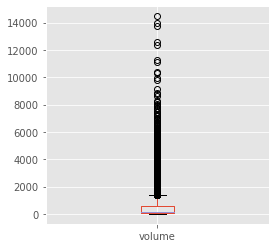

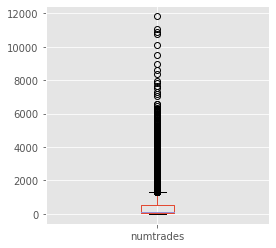

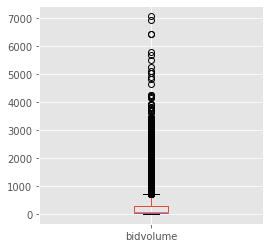

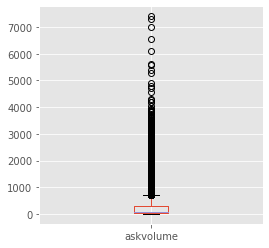

In [ ]:
outliers = ["volume", "numtrades", "bidvolume", "askvolume"]
for col in outliers:
    plt.figure(figsize=(4, 4))
    df.boxplot(column=[col])

In [ ]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [ ]:
for col in outliers:
    print(f'{col}: {len(outliers_iqr(df[col])[0])}')

volume: 6380
numtrades: 6335
bidvolume: 6380
askvolume: 6403


In [ ]:
for col in outliers:
    print(f'{col}: {len(outliers_z_score(df[col])[0])}')

volume: 1487
numtrades: 1530
bidvolume: 1495
askvolume: 1493


In [ ]:
for i in outliers:
    mean_y = np.mean(df[i])
    stdev_y = np.std(df[i])
    lower_bound = mean_y - (3 * stdev_y)
    upper_bound = mean_y + (3 * stdev_y)
    df = df[df[i]<upper_bound]
    df = df[df[i]>lower_bound]

In [ ]:
df.shape

(67121, 10)

## visualizing stock prices history

Text(0.5, 1.0, 'the total volume of stock being traded for E-mini Nasdaq-100')

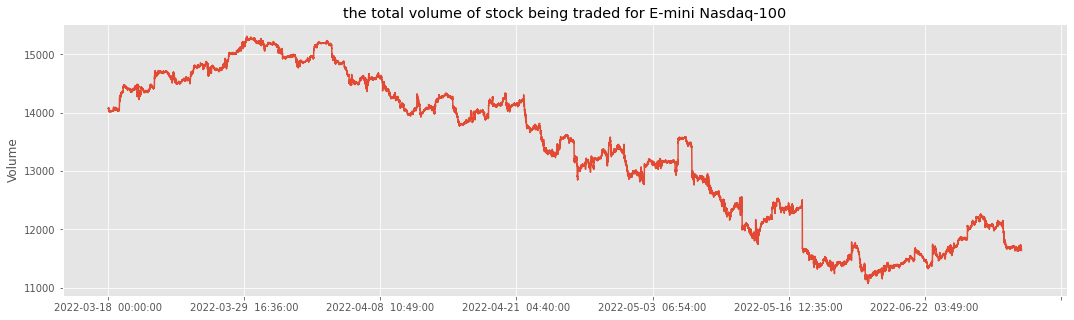

In [ ]:
plt.figure(figsize=(18,5))
df['close'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"the total volume of stock being traded for E-mini Nasdaq-100")

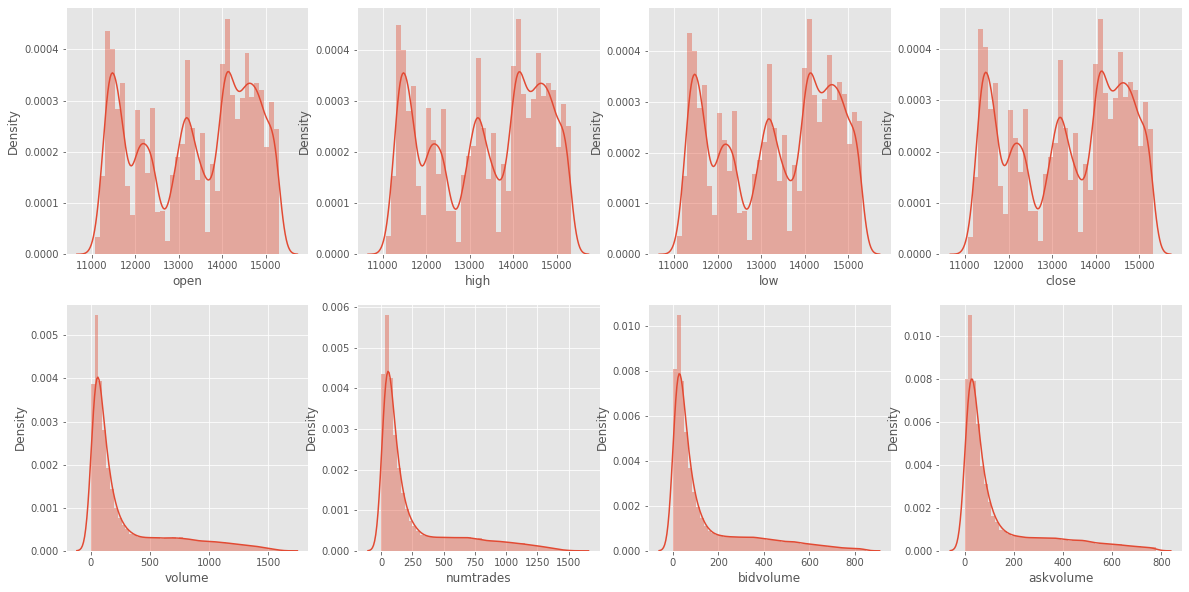

In [ ]:
features = ["open", "high",	"low", "close",	"volume",	"numtrades",	"bidvolume",	"askvolume"]
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,4,i+1)
  sb.distplot(df[col])
plt.show()

### The total volume of stock

Text(0.5, 1.0, 'the total volume of stock being traded each day for E-mini Nasdaq-100')

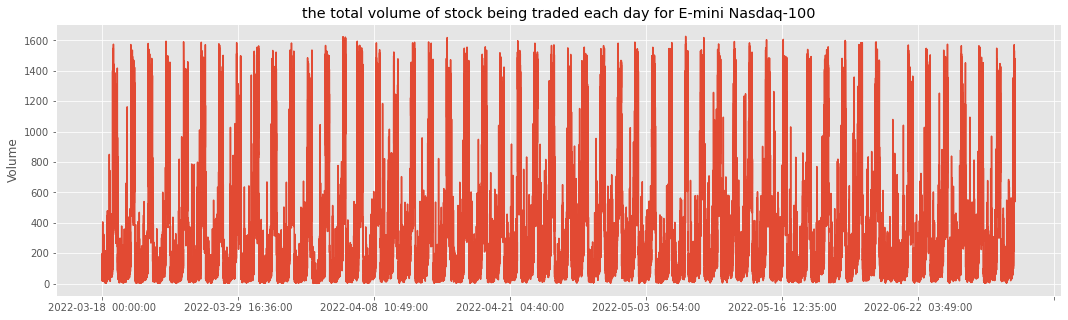

In [ ]:
plt.figure(figsize=(18,5))
df['volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title(f"the total volume of stock being traded each day for E-mini Nasdaq-100")

### Moving averages

In [ ]:
#dataframe daily
df_daily = df.copy()
df_daily.index = pd.to_datetime(df_daily.index)
df_daily = df_daily.resample('D').mean()
df_daily.dropna(axis = 0, inplace=True)
df_daily.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume
time,,,,,,,,
2022-03-18,14141.586726,14144.865140,14138.221374,14141.714801,304.256997,275.206107,151.964377,152.292621
2022-03-20,14453.708333,14456.345833,14451.579167,14453.681250,72.683333,65.491667,35.941667,36.741667
2022-03-21,14396.346698,14399.521030,14392.863404,14396.116352,282.197327,259.839623,142.043239,140.154088


In [ ]:
df_daily['ma for 5 days'] = df_daily['close'].rolling(5).mean()

<Figure size 1296x360 with 0 Axes>

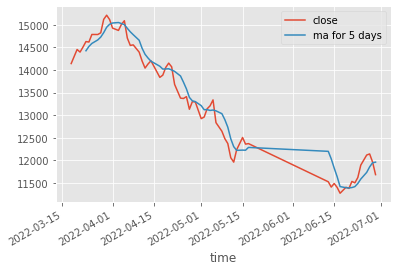

In [ ]:
plt.figure(figsize=(18,5))

df_daily[['close', 'ma for 5 days']].plot()

In [ ]:
del df_daily
gc.collect()

41688

# DATA LABELING

## close price labeling

In [ ]:
alpha_up = 0.5
alpha_down = -0.5
def filter(x):
    if x > alpha_up:
      x = +1
      return x
    elif x < alpha_down:
      x=-1
      return x
    else:
        return 0

In [ ]:
df['close_change'] = df['close'].diff()
df['close_lable'] = df["close_change"].apply(filter)
df.fillna(0, inplace=True)

In [ ]:
df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,lob_bid,lob_ask,close_change,close_lable
time,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14019.500000|1|14019.750000|2|14020.000000|1|1...,0.00,0
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14020.750000|1|14021.000000|1|14021.250000|1|1...,0.25,0
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,200.000000|1|578.750000|1|586.500000|1|6490.00...,14022.500000|3|14022.750000|1|14023.000000|1|1...,0.00,0


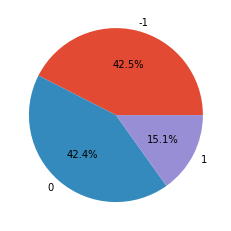

In [ ]:
plt.pie(df['close_lable'].value_counts().values,
        labels=[-1, 0, 1], autopct='%1.1f%%')
plt.show()

## ask-bid orders labeling [DEEPLOB](https://ieeexplore.ieee.org/document/8673598/references#references)

### ask column

In [ ]:
df['lob_ask'] = df["lob_ask"].str.split('|')

In [ ]:
for row in df.index:
  close = df.loc[row, "close"]
  lenght = len(df.loc[row, "lob_ask"])
  for index in range(lenght):
    number = float( df.loc[row, "lob_ask"][index])
    if number > close:
      df.loc[row, "lob_ask"] = str(df.loc[row, "lob_ask"][index:index+20])
      break

In [ ]:
df["lob_ask"] = df["lob_ask"].str.replace('[',"")
df["lob_ask"] = df["lob_ask"].str.replace(']',"")

df_ask = df["lob_ask"].str.split(',', expand=True)
df.drop(columns=["lob_ask"], inplace=True)

In [ ]:
for i in range(20):
  df_ask[i] = df_ask[i].str.replace("'","")
  df_ask[i] = df_ask[i].astype(float)

In [ ]:
ask_cols = [f'ask{i}' for i in range(20, 40)]
df_ask.columns = ask_cols

In [ ]:
df_ask.head(3)

,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39
time,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:01:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:02:00,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0


### bid cloumn

In [ ]:
df['lob_bid'] = df["lob_bid"].str.split('|')

In [ ]:
keys = [i for i in range(20)]
values = [itemgetter(-i) for i in range(2, 22)] 
 
myDict = { k:v for (k,v) in zip(keys, values)} 
df_bid = df['lob_bid'].transform(myDict)
df.drop(columns=["lob_bid"], inplace=True)

In [ ]:
for i in range(20):
  df_bid[i] = df_bid[i].astype(float)

In [ ]:
bid_cols = [f'bid{i}' for i in range(19,-1,-1)]
df_bid.columns = bid_cols

In [ ]:
df_bid = df_bid[[f'bid{i}' for i in range(20)]]

In [ ]:
df_bid.head(3)

,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19
time,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14024.25,2.0,14024.50,1.0,14024.75,1.0,14025.00,1.0,14025.25,2.0,14025.50,1.0,14025.75,1.0,14026.00,1.0,14026.25,2.0,14026.50,1.0
2022-03-18 00:01:00,14022.25,2.0,14022.50,2.0,14022.75,1.0,14023.00,1.0,14023.25,3.0,14023.50,2.0,14023.75,1.0,14024.00,1.0,14024.25,1.0,14024.50,2.0
2022-03-18 00:02:00,14023.00,2.0,14023.25,1.0,14023.50,1.0,14023.75,2.0,14024.00,1.0,14024.25,1.0,14024.50,1.0,14024.75,1.0,14025.00,2.0,14025.25,1.0


### bid & ask

In [ ]:
df_bidask =  pd.concat([df_bid, df_ask], axis=1)
df_bidask.head(3)

,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14024.25,2.0,14024.50,1.0,14024.75,1.0,14025.00,1.0,14025.25,2.0,14025.50,1.0,14025.75,1.0,14026.00,1.0,14026.25,2.0,14026.50,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:01:00,14022.25,2.0,14022.50,2.0,14022.75,1.0,14023.00,1.0,14023.25,3.0,14023.50,2.0,14023.75,1.0,14024.00,1.0,14024.25,1.0,14024.50,2.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0
2022-03-18 00:02:00,14023.00,2.0,14023.25,1.0,14023.50,1.0,14023.75,2.0,14024.00,1.0,14024.25,1.0,14024.50,1.0,14024.75,1.0,14025.00,2.0,14025.25,1.0,14066.5,2.0,14067.0,2.0,14067.5,2.0,14068.0,3.0,14068.25,1.0,14068.5,2.0,14069.0,4.0,14069.5,2.0,14070.0,8.0,14070.25,2.0


In [ ]:
scaler = StandardScaler()  

bidask = scaler.fit_transform(df_bidask)
df_bidask = pd.DataFrame(bidask, index=df_bidask.index, columns=df_bidask.columns)
# df_bidask=pd.DataFrame(df_bidask, columns=['bid0', 'bid1', 'bid2',
#        'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
#        'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
#        'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
#        'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
#        'ask35', 'ask36', 'ask37', 'ask38', 'ask39'])

In [ ]:
alpha_up = 0.0005
alpha_down = -0.0005
def filter(x):
    if x > alpha_up:
      x = +1
      return x
    elif x < alpha_down:
      x=-1
      return x
    else:
        return 0

In [ ]:
df_bidask['p_b'] = df_bidask["bid18"]
df_bidask['p_a'] = df_bidask["ask20"]
df_bidask['p_t'] = (df_bidask['p_b']+df_bidask['p_a'])/2
df_bidask['m_+'] = (df_bidask['p_b'].rolling(2).sum())/2
df_bidask['l_t'] = (df_bidask['m_+'] - df_bidask['p_t']) / df_bidask['p_t']
df_bidask.fillna(0, inplace=True)
df_bidask['l_t_lable'] = df_bidask["l_t"].apply(filter)

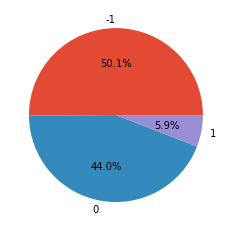

In [ ]:
plt.pie(df_bidask['l_t_lable'].value_counts().values,
        labels=[-1,0,1], autopct='%1.1f%%')
plt.show()

In [ ]:
df_bidask.head(3)

,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39,p_b,p_a,p_t,m_+,l_t,l_t_lable
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,0.562161,-0.199037,0.562161,-0.587085,0.562161,-0.507191,0.562160,-0.492321,0.562160,-0.035384,0.562160,-0.523799,0.562159,-0.600543,0.562158,-0.569687,0.562158,0.154312,0.562153,-0.344443,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.562153,0.563979,0.563066,0.000000,0.000000,0
2022-03-18 00:01:00,0.560569,-0.199037,0.560569,-0.150239,0.560569,-0.507191,0.560568,-0.492321,0.560568,0.445878,0.560568,-0.004901,0.560567,-0.600543,0.560566,-0.569687,0.560566,-0.515952,0.560561,0.333723,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.560561,0.563979,0.562270,0.561357,-0.001624,-1
2022-03-18 00:02:00,0.561166,-0.199037,0.561166,-0.587085,0.561166,-0.507191,0.561165,-0.063754,0.561165,-0.516646,0.561165,-0.523799,0.561164,-0.600543,0.561163,-0.569687,0.561163,0.154312,0.561158,-0.344443,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.561158,0.563979,0.562569,0.560859,-0.003039,-1


In [ ]:
total_df = pd.concat([df, df_bidask], axis=1)
total_df.head(3)

,open,high,low,close,volume,numtrades,bidvolume,askvolume,close_change,close_lable,bid0,bid1,bid2,bid3,bid4,bid5,bid6,bid7,bid8,bid9,bid10,bid11,bid12,bid13,bid14,bid15,bid16,bid17,bid18,bid19,ask20,ask21,ask22,ask23,ask24,ask25,ask26,ask27,ask28,ask29,ask30,ask31,ask32,ask33,ask34,ask35,ask36,ask37,ask38,ask39,p_b,p_a,p_t,m_+,l_t,l_t_lable
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-18 00:00:00,14066.5,14069.75,14061.75,14066.00,145.0,144.0,60.0,85.0,0.00,0,0.562161,-0.199037,0.562161,-0.587085,0.562161,-0.507191,0.562160,-0.492321,0.562160,-0.035384,0.562160,-0.523799,0.562159,-0.600543,0.562158,-0.569687,0.562158,0.154312,0.562153,-0.344443,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.562153,0.563979,0.563066,0.000000,0.000000,0
2022-03-18 00:01:00,14064.5,14067.75,14063.00,14066.25,66.0,64.0,36.0,30.0,0.25,0,0.560569,-0.199037,0.560569,-0.150239,0.560569,-0.507191,0.560568,-0.492321,0.560568,0.445878,0.560568,-0.004901,0.560567,-0.600543,0.560566,-0.569687,0.560566,-0.515952,0.560561,0.333723,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.560561,0.563979,0.562270,0.561357,-0.001624,-1
2022-03-18 00:02:00,14067.0,14068.00,14064.75,14066.25,68.0,64.0,36.0,32.0,0.00,0,0.561166,-0.199037,0.561166,-0.587085,0.561166,-0.507191,0.561165,-0.063754,0.561165,-0.516646,0.561165,-0.523799,0.561164,-0.600543,0.561163,-0.569687,0.561163,0.154312,0.561158,-0.344443,0.563979,-0.319181,0.564166,-0.332552,0.564354,-0.321784,0.564541,-0.151661,0.564532,-0.54633,0.564522,-0.366536,0.56471,-0.021388,0.564897,-0.436125,0.565084,0.573427,0.565074,-0.426986,0.561158,0.563979,0.562569,0.560859,-0.003039,-1


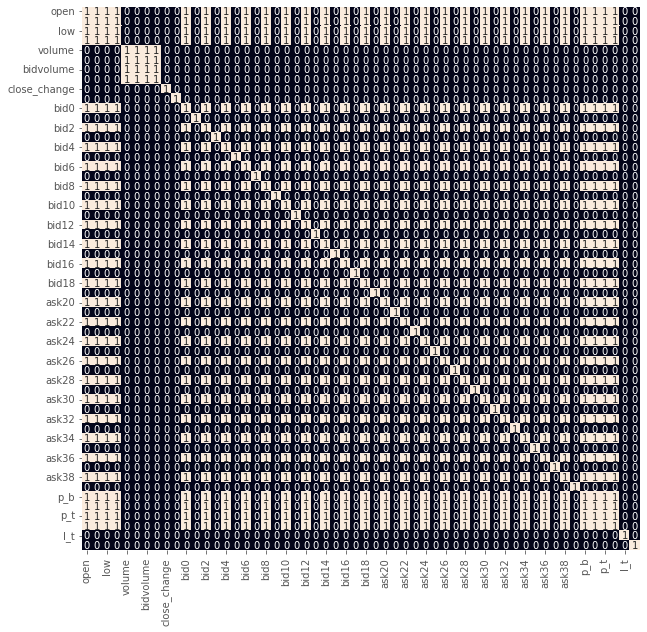

In [ ]:
plt.figure(figsize=(10, 10))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(total_df.corr() > 0.7, annot=True, cbar=False)
plt.show()

In [ ]:
total_df.to_csv("total.csv")

In [ ]:
gc.collect()

158416

# ML MODELING, BACKTESTING

### CLASSIC ML use classification 

In [ ]:
df.shape

(67121, 10)

In [ ]:
df_bidask.shape

(67121, 46)

In [ ]:
total_df.shape

(67121, 56)

In [ ]:
valid_horizon = 67121
67121 // 5

13424

In [ ]:
valid_horizon = 13424
train = total_df.head(-valid_horizon).copy()
test = total_df.tail(valid_horizon)

In [ ]:
total_df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'numtrades', 'bidvolume',
       'askvolume', 'close_change', 'close_lable', 'bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39', 'p_b', 'p_a', 'p_t', 'm_+',
       'l_t', 'l_t_lable'],
      dtype='object')

In [ ]:
# x_train = train[['open', 'high', 'low',	"volume", "numtrades", "p_t", "bidvolume",	"askvolume", "bid18", "ask20"]]
y_train = train['close_lable']
x_train = train[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
# x_test = test[['open', 'high', 'low',	"volume", "numtrades", "p_t", "bidvolume",	"askvolume", "bid18", "ask20"]]
x_test = test[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
y_test = test['close_lable']
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [ ]:
print(f'x_train shape: {x_train.shape}, x_test shape: {x_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}')

x_train shape: (53697, 40), x_test shape: (13424, 40), y_train shape: (53697, 1), y_test shape: (13424, 1)


In [ ]:
scaler = StandardScaler()

In [ ]:
scaler = scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
models = [LogisticRegression(), XGBClassifier()]
# SVC(kernel='poly', probability=True)

for i in range(2):
  models[i].fit(x_train, y_train )
 
  print(f'{models[i]} : ')
  y_train_predict = models[i].predict(x_train)
  y_train_predict = y_train_predict.reshape(-1,1)
  y_test_predict = models[i].predict(x_test)
  y_test_predict = y_test_predict.reshape(-1,1)
  
  print('Training f1 Score : ', metrics.f1_score(y_train , y_train_predict, average=None))
  print('Test f1 Score : ', metrics.f1_score(y_test , y_test_predict, average=None))
  print()

LogisticRegression() : 
Training f1 Score :  [0.63438039 0.         0.58921991]
Test f1 Score :  [0.62870006 0.         0.28999168]

XGBClassifier(objective='multi:softprob') : 
Training f1 Score :  [0.62893646 0.01099164 0.55568746]
Test f1 Score :  [0.61006146 0.00107009 0.56440678]



## Backtest XGBClassifier 

In [ ]:
backtest_data = total_df[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39', "close"]]
featuers = backtest_data[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
featuers = StandardScaler().fit_transform(featuers)
featuers = pd.DataFrame(featuers, columns = ['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39'])

In [ ]:
buy_signals = []
sell_signals =[]
trigger = 0
for x in range(len(backtest_data)):
  featuer = featuers.iloc[x].to_numpy()
  predict = models[0].predict(featuer.reshape(1, -1))
  if int(predict[0]) == 1 and trigger != 1:
    buy_signals.append(backtest_data["close"].iloc[x])
    sell_signals.append(float('nan'))
    trigger = 1
  elif predict[0] == -1 and trigger != -1:
    sell_signals.append(backtest_data["close"].iloc[x])
    buy_signals.append(float('nan'))
    trigger = -1
  else:
    buy_signals.append(float('nan'))
    sell_signals.append(float('nan'))


In [ ]:
backtest_data['Buy Signals'] = buy_signals
backtest_data['Sell Signals'] = sell_signals

In [ ]:
# plt.plot(backtest_data['close'], label='Share Price', color='lightgray', alpha=0.5)
# plt.scatter(backtest_data.index, backtest_data['Buy Signals'], label='Buy Signal', marker="^", color="#00ff00", lw=1)
# plt.scatter(backtest_data.index, backtest_data['Sell Signals'], label='Sell Signal', marker="v", color="#ff0000", lw=1)
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# Compute the percentage of variation of the asset
backtest_data["pct"] = backtest_data["close"].pct_change(1)
backtest_data.fillna(0, inplace=True)

In [ ]:
def filter_up(x):
    if x > 0:
      return 1
    else:
      return 0
def filter_down(x):
    if x > 0:
      return -1
    else:
      return 0

In [ ]:
backtest_data["signal_long"] = backtest_data["Buy Signals"].apply(filter_up)
backtest_data["signal_short"] = backtest_data["Sell Signals"].apply(filter_down)

In [ ]:
# Compute the positions
backtest_data["Position"] = (backtest_data["signal_short"].fillna(method="ffill")+ backtest_data["signal_long"].fillna(method="ffill"))

# Compute the return of the strategy
backtest_data["return"] = backtest_data["pct"]*(backtest_data["Position"].shift(1))

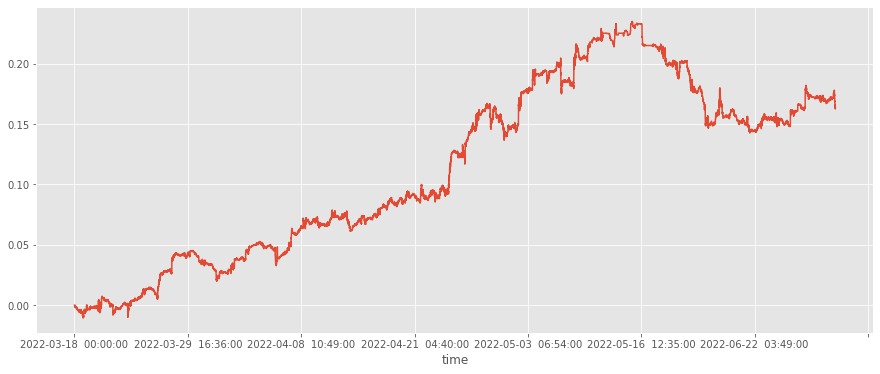

In [ ]:
backtest_data["return"].cumsum().plot(figsize=(15,6))

In [ ]:
def drawdown_function(serie):
# We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1
# We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)
# We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
# We compute drawdown
drawdown = drawdown_function(backtest_data["return"])
backtest_data["drawdown"] = drawdown 
# Computation Max drawdown
max_drawdown =  -np.min(drawdown)*100
print(f"Max drawdown: {np.round(max_drawdown,1)} %")

Max drawdown: 7.5 %


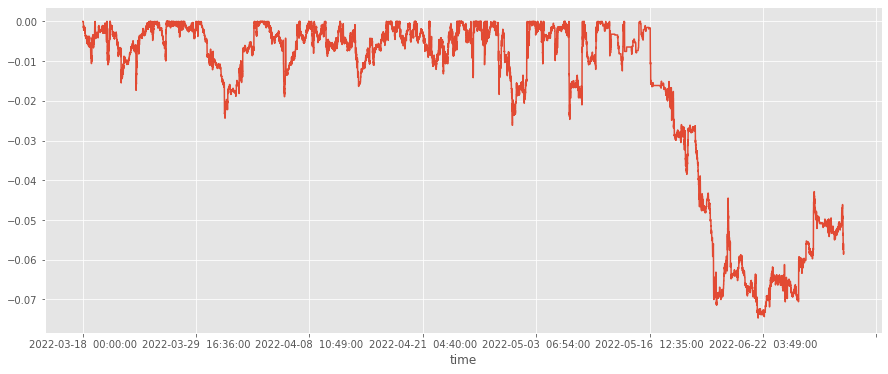

In [ ]:
plt.figure(figsize=(15,6))
backtest_data["drawdown"].plot()

plt.show()

## DNN

### [DEEPLOB](https://ieeexplore.ieee.org/document/8673598/references#references) 


In [ ]:
def prepare_x(data):
    df1 = data[['bid0', 'bid1', 'bid2',
       'bid3', 'bid4', 'bid5', 'bid6', 'bid7', 'bid8', 'bid9', 'bid10',
       'bid11', 'bid12', 'bid13', 'bid14', 'bid15', 'bid16', 'bid17', 'bid18',
       'bid19', 'ask20', 'ask21', 'ask22', 'ask23', 'ask24', 'ask25', 'ask26',
       'ask27', 'ask28', 'ask29', 'ask30', 'ask31', 'ask32', 'ask33', 'ask34',
       'ask35', 'ask36', 'ask37', 'ask38', 'ask39']]
    return np.array(df1)

def get_label(data):
    lob = data[['close_lable', 'l_t_lable']]
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k]
    y = np_utils.to_categorical(y, 3)
    return x, y

In [ ]:
k = 0 # which prediction horizon
T = 100 # the length of a single input
n_hiddens = 64
checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
valid_horizon = 13424
data = pd.read_csv("total.csv")
train = data.head(-valid_horizon).copy()
test = data.tail(valid_horizon)
print(train.shape, test.shape)

(53697, 57) (13424, 57)


In [ ]:
trainX_CNN, trainY_CNN = prepare_x_y(train, k, T)
valX_CNN, valY_CNN = prepare_x_y(test, k, T)
# testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)

print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
# print(testX_CNN.shape, testY_CNN.shape)

(53598, 100, 40, 1) (53598, 3)
(13325, 100, 40, 1) (13325, 3)


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))
    
    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    
    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)

    # build the output layer
    out = Dense(3, activation='softmax')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 100, 20, 32)  96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 20, 32)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 20, 32)  4128        ['leaky_re_lu[0][0]']        

In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
#epocs = 200
deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN), 
            epochs=10, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/10
419/419 - 34s - loss: 1.0174 - accuracy: 0.4252 - val_loss: 1.0057 - val_accuracy: 0.4353 - 34s/epoch - 80ms/step
Epoch 2/10
419/419 - 18s - loss: 0.9846 - accuracy: 0.4878 - val_loss: 0.9453 - val_accuracy: 0.5481 - 18s/epoch - 44ms/step
Epoch 3/10
419/419 - 19s - loss: 0.9437 - accuracy: 0.5417 - val_loss: 0.9346 - val_accuracy: 0.5509 - 19s/epoch - 45ms/step
Epoch 4/10
419/419 - 19s - loss: 0.9371 - accuracy: 0.5476 - val_loss: 0.9317 - val_accuracy: 0.5544 - 19s/epoch - 45ms/step
Epoch 5/10
419/419 - 20s - loss: 0.9338 - accuracy: 0.5503 - val_loss: 0.9409 - val_accuracy: 0.5593 - 20s/epoch - 47ms/step
Epoch 6/10
419/419 - 18s - loss: 0.9318 - accuracy: 0.5515 - val_loss: 0.9279 - val_accuracy: 0.5595 - 18s/epoch - 44ms/step
Epoch 7/10
419/419 - 19s - loss: 0.9293 - accuracy: 0.5537 - val_loss: 0.9286 - val_accuracy: 0.5638 - 19s/epoch - 46ms/step
Epoch 8/10
419/419 - 19s - loss: 0.9284 - accuracy: 0.5556 - val_loss: 0.9303 - val_accuracy: 0.5626 - 19s/epoch - 44ms/step


In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(valX_CNN)

417/417 [==============================] - 10s 6ms/step


In [ ]:
print('accuracy_score:', metrics.accuracy_score(np.argmax(valY_CNN, axis=1), np.argmax(pred, axis=1)))
print(metrics.classification_report(np.argmax(valY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.5636022514071295
              precision    recall  f1-score   support

           0     0.2857    0.0011    0.0022      1844
           1     0.5761    0.5914    0.5837      5754
           2     0.5539    0.7168    0.6249      5727

    accuracy                         0.5636     13325
   macro avg     0.4719    0.4364    0.4036     13325
weighted avg     0.5264    0.5636    0.5209     13325



### Backtest DEEPLOB

In [ ]:
total = pd.read_csv("total.csv")
trainX_CNN, trainY_CNN = prepare_x_y(total, 0, 100)
deeplob.load_weights(checkpoint_filepath)
predict = deeplob.predict(trainX_CNN)

2095/2095 [==============================] - 12s 5ms/step


In [ ]:
pr = np.argmax(predict, axis=1).reshape(-1,1)
a = np.zeros((99,1))
pre = np.concatenate((a, pr), axis=0)
total['Position'] = pre

In [ ]:
def filter(x):
  if x==2:
    return -1
  else:
    return x

In [ ]:
total['Position'] = total['Position'].apply(filter)
# Compute the percentage of variation of the asset
total["pct"] = total["close"].pct_change(1)
total.fillna(0, inplace=True)
# Compute the return of the strategy
total["return"] = total["pct"]*(total["Position"].shift(1))

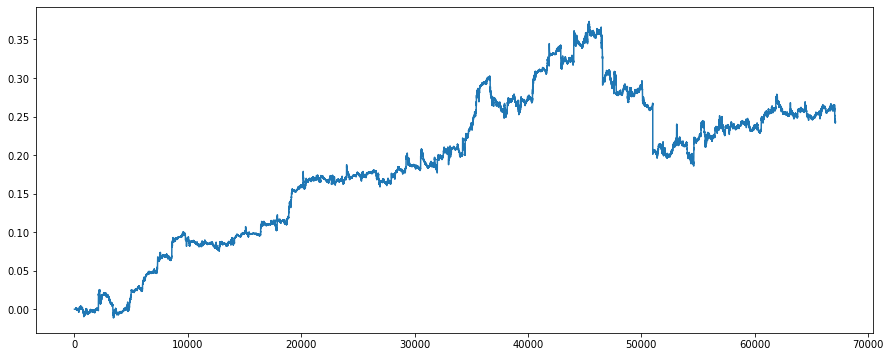

In [ ]:
total["return"].cumsum().plot(figsize=(15,6))

In [ ]:
def drawdown_function(serie):
# We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1
# We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)
# We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [ ]:
# We compute drawdown
drawdown = drawdown_function(total["return"])
total["drawdown"] = drawdown 
# Computation Max drawdown
max_drawdown =  -np.min(drawdown)*100
print(f"Max drawdown: {np.round(max_drawdown,1)} %")

Max drawdown: 13.7 %


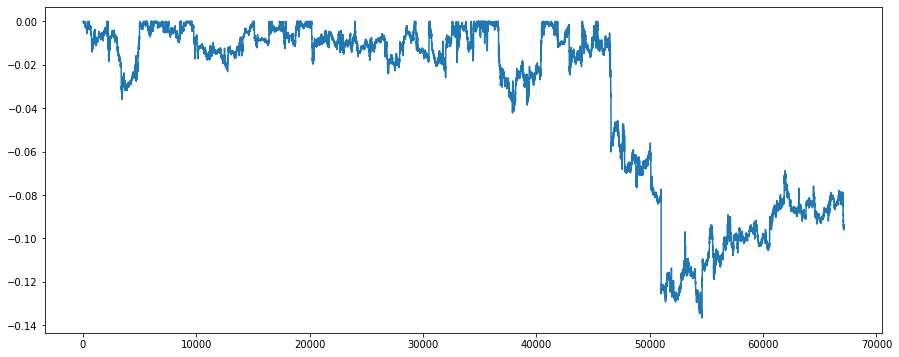

In [ ]:
plt.figure(figsize=(15,6))
total["drawdown"].plot()

plt.show()